## Aufgabe: Krebs diagnostizieren

Wir haben Patientendaten für Brustkrebs im Internet gefunden. Können wir ein Modell trainieren, welches die Diagnose stellen kann?

=> Quelle der Daten: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

Es geht also darum, die Art des Tumors (Spalte: `diagnosis`) vorherzusagen. Mit einem gut funktionierenden Modell könnten wir u.U. einige Operationen oder zumindest viele Sorgen sparen.

- **M:** Malignant, bösartiger Tumor
- **B:** Benign, gutartiger Krebs

**Aufgabe:**
- Trainiere ein Modell
- Du kannst die Spalte `diagnosis` nicht direkt vorhersagen. Zuvor muss sie in eine Spalte mit 0- und 1-Werten konvertiert werden
- Evaluiere verschiedene Klassifizierungs-Modelle... welches funktioniert am besten?
- Beachte, dass du für einige Modelle die Daten skalieren musst / solltest
- Achte darauf, dass du Testdaten zurückhälst - nutze diese erst ganz zum Schluss, um die Genauigkeit auf bisher noch nie gesehende Daten zu ermitteln. 
  - **Wichtig:** Damit dies aussagekräftig ist, dürfen wir die Genauigkeit auf den Testdaten erst *nach* der Auswahl des Modells (und dem Tunen der Parameter) beurteilen!
- Die Spalte `id` ist vermutlich für unser Modell nicht aussagekräftig. Ggf. solltest du diese Spalte aus den Daten entfernen.

  
**Bonusfragen:**
- Ggf. kann sich für einige Modelle auch eine PCA lohnen?
- Wie viele Spalten benötigt das Modell tatsächlich? Kann es auch mit weniger Spalten auskommen? Dann müsste unser Arzt weniger Werte messen und in den Computer eingeben, und würde wertvolle Zeit sparen!

In [11]:
import pandas as pd
import lightgbm as lgb

df = pd.read_csv("../data/Krebs/cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [12]:
#dropping the id column

df.drop("id", axis=1, inplace=True)

In [13]:
#cleaning the data

df.dropna(inplace=True)

In [14]:
#converting the diagnosis column to binary

df["diagnosis"] = df["diagnosis"].map({"M":1, "B":0})

## EDA

In [15]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [17]:
#shape of the data
df.shape

(569, 31)

In [18]:
#columns
df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [19]:
#numerical basics
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [20]:
#corellation between target (diagnosis) and all other features
#sort by impact on target

df.corr()["diagnosis"].sort_values(ascending=False)


diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

<Axes: >

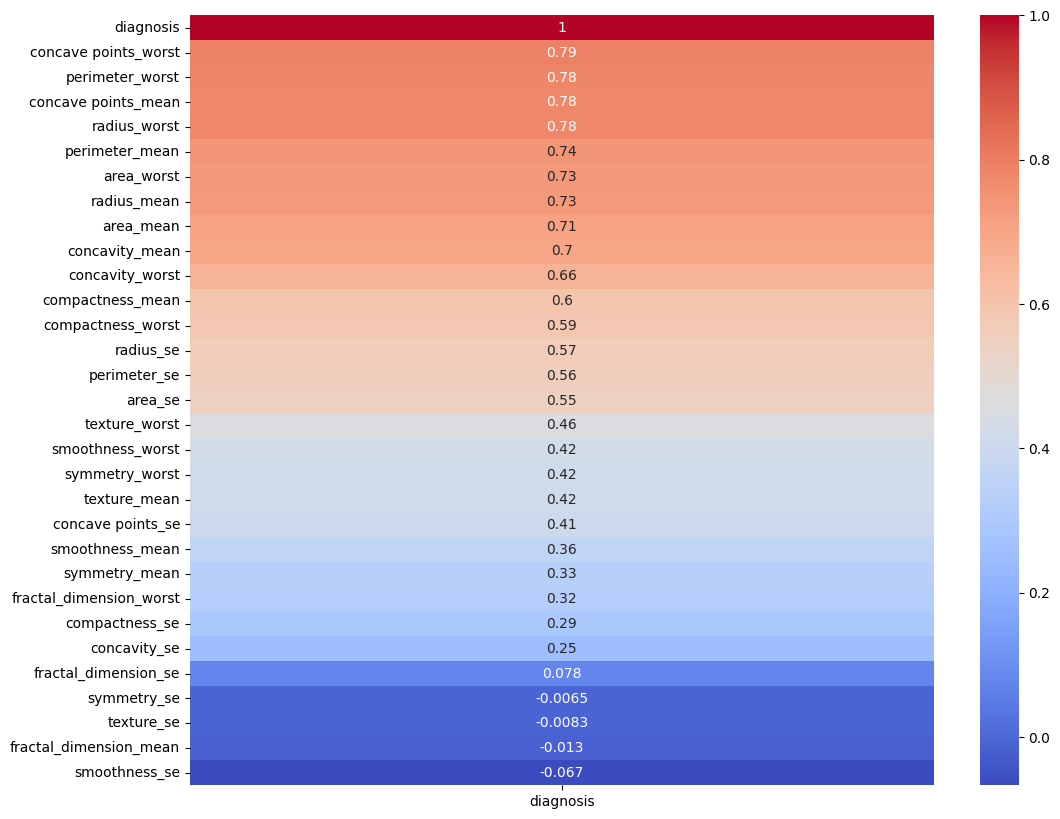

In [21]:
#creating a heat map only with the target and the features with the 10 highest impact on the target

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

sns.heatmap(df.corr()[["diagnosis"]].sort_values("diagnosis", ascending=False), annot=True, cmap="coolwarm")

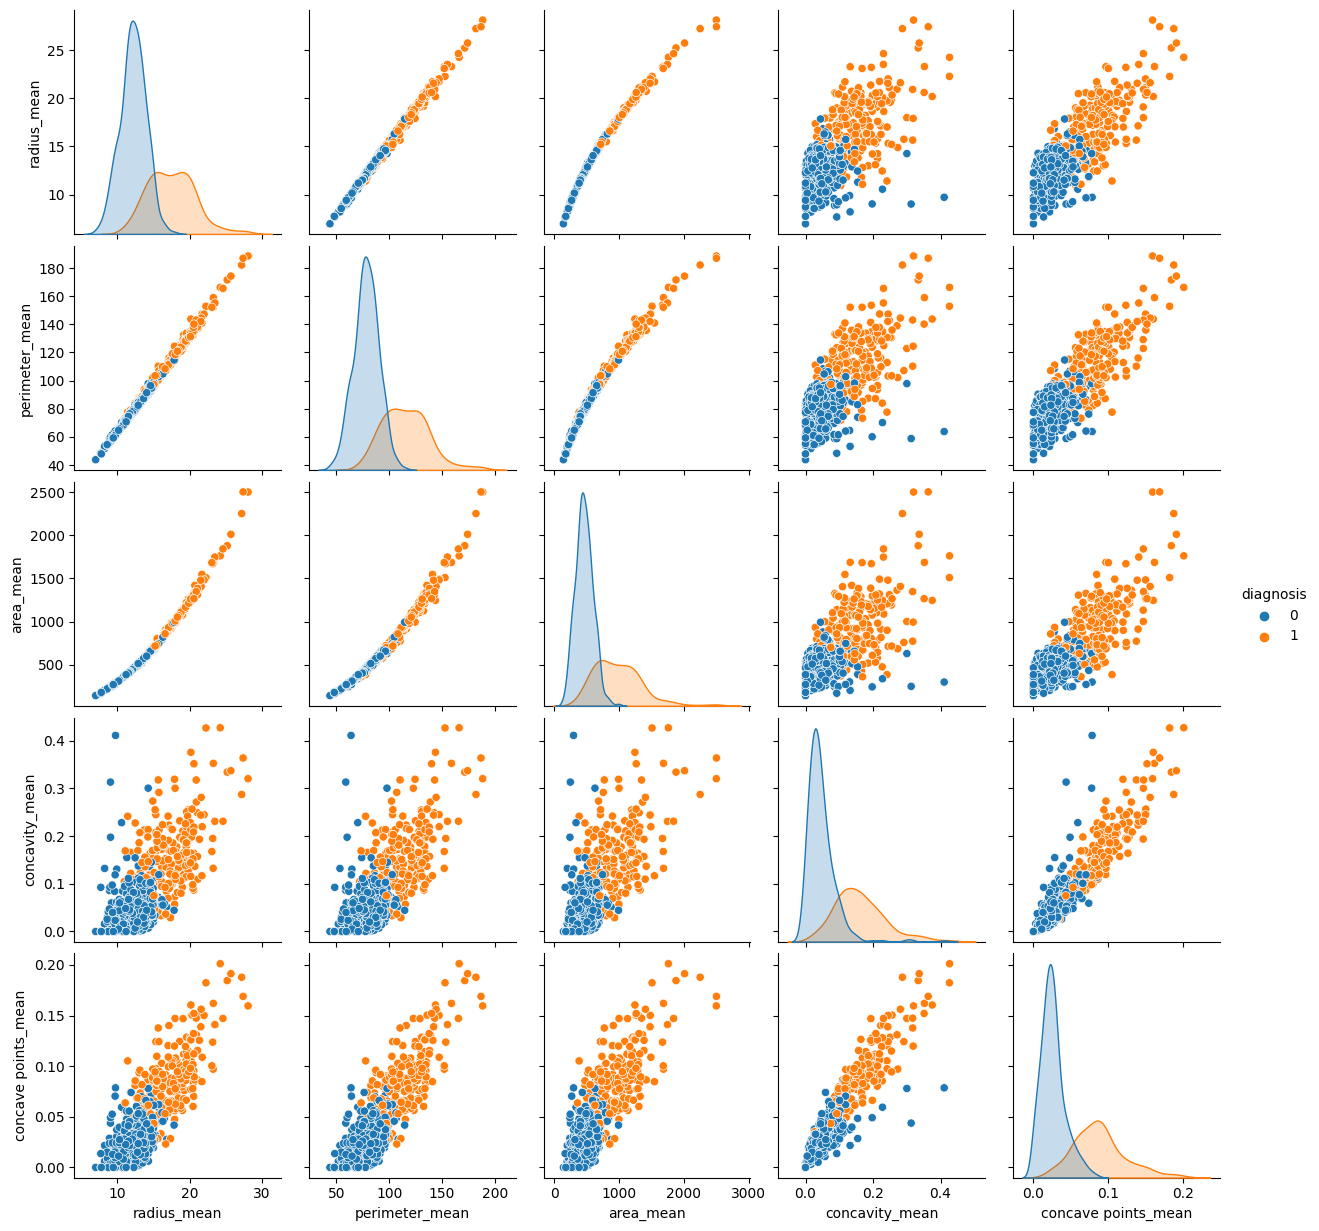

In [22]:
#creating more vizualisations

sns.pairplot(df, hue="diagnosis", vars=["radius_mean", "perimeter_mean", "area_mean", "concavity_mean", "concave points_mean"])

## 0. Splitting of the Data

In [23]:
#splitting the data into train and test data

from sklearn.model_selection import train_test_split

X = df.drop("diagnosis", axis=1) #all features except the target | wir könnten auch die wichtigsten features einzeln auswählen

y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)



In [24]:
#scaling the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



## 1. Logistical Regression

* In the end I expect a certain accuracy level between 0 and 1, which I can compare with the other approaches
* tends rather to underfit then to overfit

In [25]:
#fitting the logistical model

from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()

logmodel.fit(X_train, y_train)

LogisticRegression()

In [26]:
#predicting the test data

y_pred = logmodel.predict(X_test)


In [57]:
#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))




The accuracy is 0.972027972027972
The F1 score is 0.9636363636363636
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        88
           1       0.96      0.96      0.96        55

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143
This is the classification report:
The logloss is 1.0082140808144657


## 2. Using nearest neighbour (KNN)

In [58]:
# using the KNN model

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

#training the model
knn.fit(X_train, y_train)

#predicting the test data
y_pred = knn.predict(X_test)

#evaluating the model

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))


The accuracy is 0.9370629370629371
The F1 score is 0.918918918918919
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        88
           1       0.91      0.93      0.92        55

    accuracy                           0.94       143
   macro avg       0.93      0.94      0.93       143
weighted avg       0.94      0.94      0.94       143
This is the classification report:
The logloss is 2.268481681832548


## 3. Using SVM

In [59]:
#using SVM model
from sklearn.svm import SVC
svc = SVC()

#training
svc.fit(X_train, y_train)

#predicting
y_pred = svc.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))

The accuracy is 0.9790209790209791
The F1 score is 0.9724770642201834
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        88
           1       0.98      0.96      0.97        55

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143
This is the classification report:
The logloss is 0.7561605606108495


## 4. Using a decision tree model

In [60]:
#using a decision tree

from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

#training
dtree.fit(X_train, y_train)

#predicting
y_pred = dtree.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))

The accuracy is 0.8881118881118881
The F1 score is 0.8571428571428571
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        88
           1       0.84      0.87      0.86        55

    accuracy                           0.89       143
   macro avg       0.88      0.89      0.88       143
weighted avg       0.89      0.89      0.89       143
This is the classification report:
The logloss is 4.032856323257863


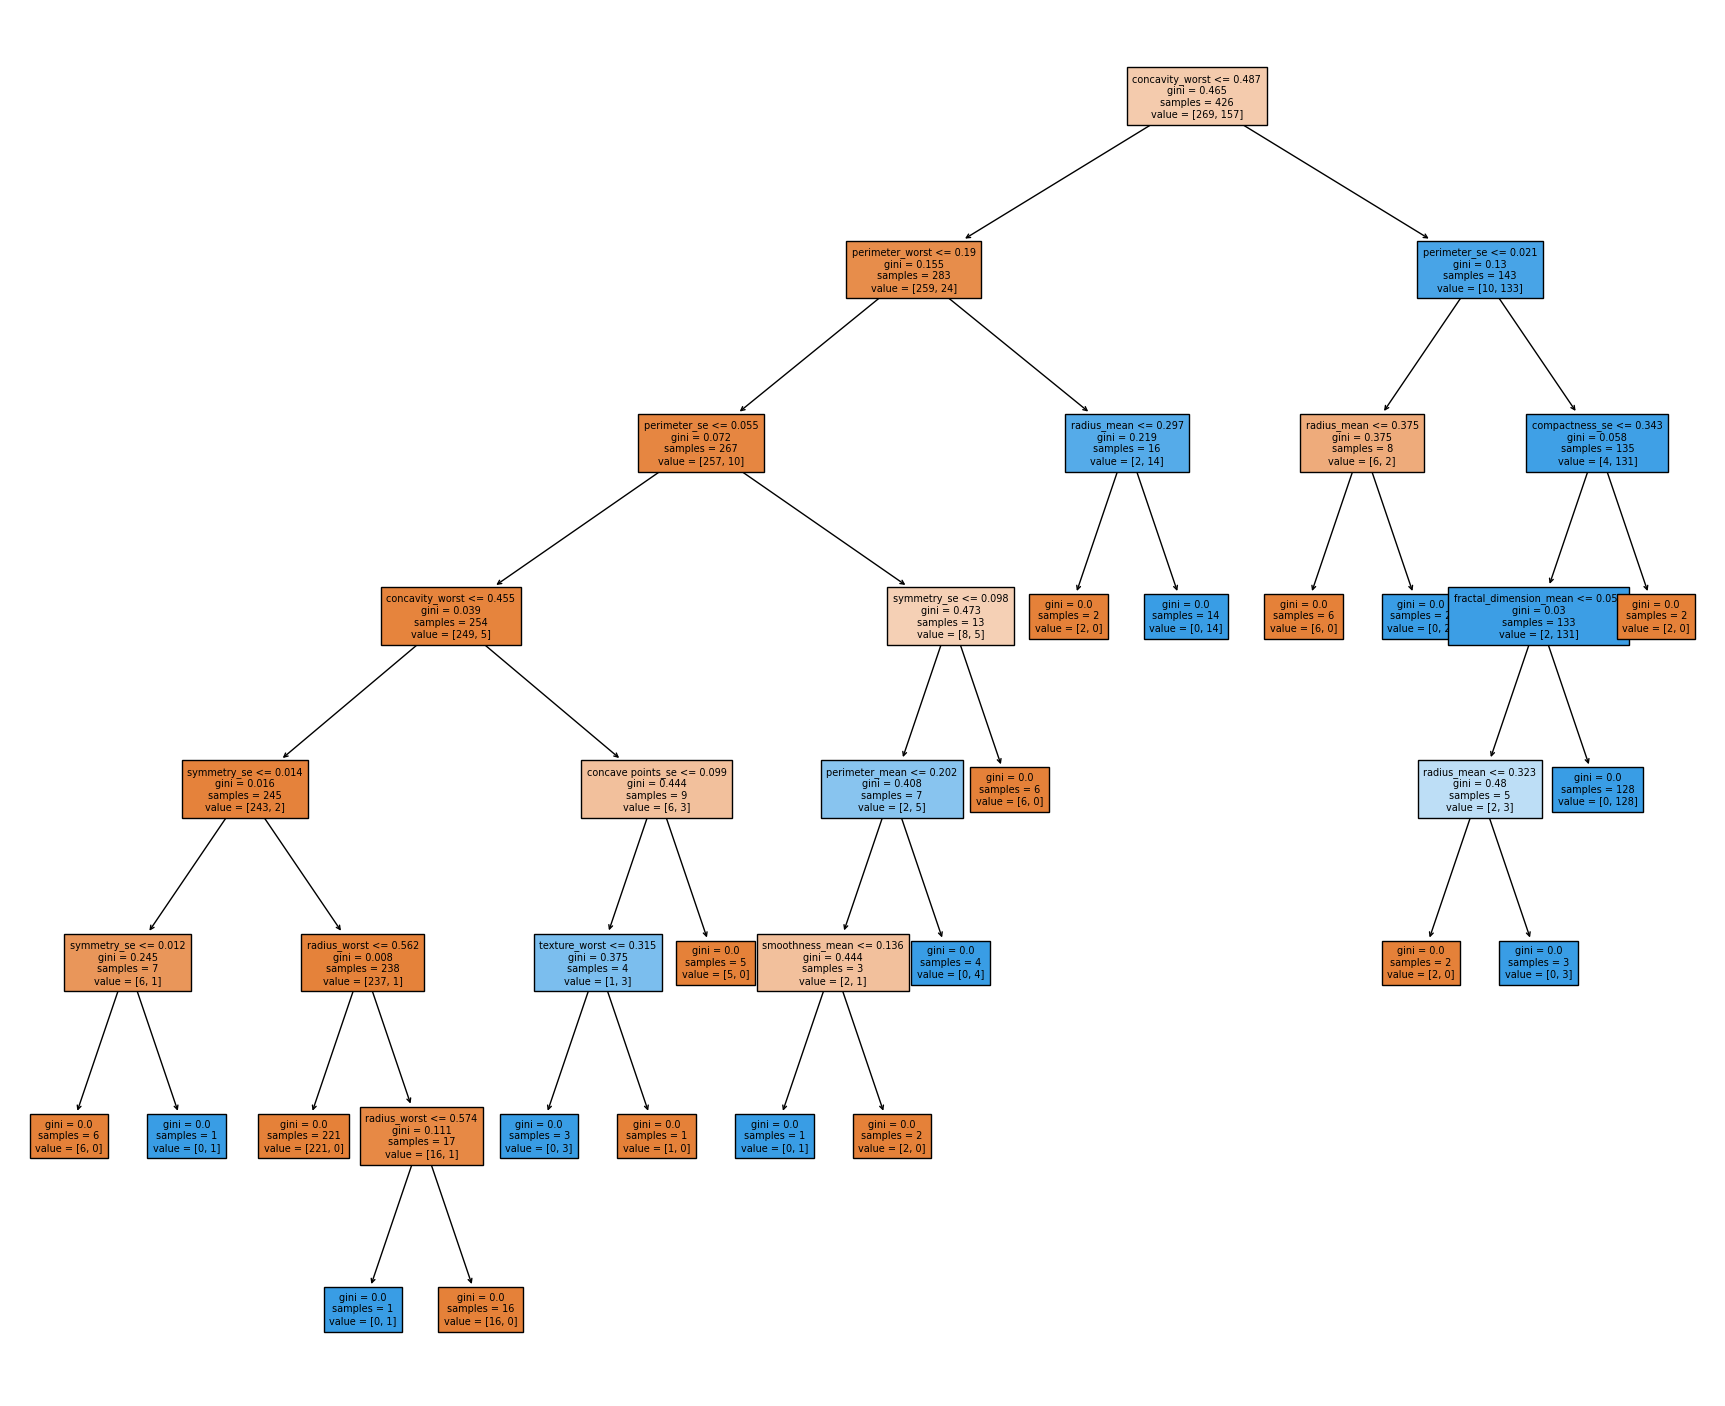

In [31]:
#plotting the tree

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Erstelle die Figur mit gewünschter Größe
plt.figure(figsize=(22, 18))

# Plotte den Baum
plot_tree(dtree, feature_names=df.columns, filled=True, fontsize=7)

# Zeige das Bild an
plt.show()


## 5. Random forrest

In [61]:
#Using random forrest

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)

#training
rfc.fit(X_train, y_train)

#predicting
y_pred = rfc.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))

The accuracy is 0.972027972027972
The F1 score is 0.9642857142857142
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        88
           1       0.95      0.98      0.96        55

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143
This is the classification report:
The logloss is 1.0082140808144657


## 6. Trying out the Light GBM

In [62]:
#lightgbm
lgbm = lgb.LGBMClassifier()

#training
lgbm.fit(X_train, y_train)

#predicting
y_pred = lgbm.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))



The accuracy is 0.9790209790209791
The F1 score is 0.972972972972973
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        88
           1       0.96      0.98      0.97        55

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143
This is the classification report:
The logloss is 0.7561605606108495


## 7. Using XG Boost

In [63]:
#using xgboost

import xgboost as xgb
xgb = xgb.XGBClassifier()

#training
xgb.fit(X_train, y_train)

#predicting
y_pred = xgb.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))

The accuracy is 0.9790209790209791
The F1 score is 0.9724770642201834
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        88
           1       0.98      0.96      0.97        55

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143
This is the classification report:
The logloss is 0.7561605606108495


## 8. Using catboost

In [64]:
#using catboost

from catboost import CatBoostClassifier
cat = CatBoostClassifier()

#training
cat.fit(X_train, y_train)

#predicting
y_pred = cat.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))

Learning rate set to 0.007156
0:	learn: 0.6824784	total: 4.99ms	remaining: 4.98s
1:	learn: 0.6720264	total: 9.06ms	remaining: 4.52s
2:	learn: 0.6603699	total: 12.5ms	remaining: 4.16s
3:	learn: 0.6494999	total: 16ms	remaining: 3.99s
4:	learn: 0.6381394	total: 18.7ms	remaining: 3.71s
5:	learn: 0.6290749	total: 21.1ms	remaining: 3.5s
6:	learn: 0.6183747	total: 23.7ms	remaining: 3.37s
7:	learn: 0.6082393	total: 27.3ms	remaining: 3.38s
8:	learn: 0.5976679	total: 30ms	remaining: 3.31s
9:	learn: 0.5893318	total: 34.8ms	remaining: 3.44s
10:	learn: 0.5800929	total: 37.4ms	remaining: 3.36s
11:	learn: 0.5707131	total: 39.6ms	remaining: 3.26s
12:	learn: 0.5618494	total: 42ms	remaining: 3.19s
13:	learn: 0.5526927	total: 45ms	remaining: 3.17s
14:	learn: 0.5434997	total: 47.4ms	remaining: 3.11s
15:	learn: 0.5352390	total: 49.6ms	remaining: 3.05s
16:	learn: 0.5279933	total: 51.8ms	remaining: 2.99s
17:	learn: 0.5200666	total: 54ms	remaining: 2.95s
18:	learn: 0.5115531	total: 56.4ms	remaining: 2.91s
19:

## 9. Naive Bayes

In [65]:
#using Naive Bayes
from sklearn.naive_bayes import GaussianNB

#creating the model

gnb = GaussianNB()

#training
gnb.fit(X_train, y_train)

#predicting
y_pred = gnb.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))

The accuracy is 0.9300699300699301
The F1 score is 0.9107142857142856
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        88
           1       0.89      0.93      0.91        55

    accuracy                           0.93       143
   macro avg       0.92      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143
This is the classification report:
The logloss is 2.520535202036165


## 10. Using NEURAL NETWORKS

In [66]:
#using neural network

from sklearn.neural_network import MLPClassifier

#creating the model
mlp = MLPClassifier()

#training
mlp.fit(X_train, y_train)

#predicting
y_pred = mlp.predict(X_test)

#evaluating

#calculating the accuracy
from sklearn.metrics import accuracy_score
accuracy = (accuracy_score(y_test, y_pred))
print("The accuracy is " + str(accuracy))

#f1 score
from sklearn.metrics import f1_score
F1 = (f1_score(y_test, y_pred))
print("The F1 score is " + str(F1))

#classification report
from sklearn.metrics import classification_report
print(str(classification_report(y_test, y_pred))+ 
"This is the classification report:")

#logloss
from sklearn.metrics import log_loss
logloss = (log_loss(y_test, y_pred))
print("The logloss is " + str(logloss))

The accuracy is 0.9790209790209791
The F1 score is 0.972972972972973
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        88
           1       0.96      0.98      0.97        55

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143
This is the classification report:
The logloss is 0.7561605606108495


/Users/robertkurtz/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# §: Welches Model bietet sich also an?

* tatsächlich spricht vieles für die Logistische Regression
* sie performt gut auch schon mit wenig variabeln und ermöglicht mit pred.proba auch die jeweilige Sicherheit der Entscheidung nachzuvollziehen
* gut um Entscheidungsgrenze einzuführen z.B. ab einer Gefahr von 25% Chemo Therapie...